In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import nltk
from nltk.corpus import stopwords

import os
import re
import string


In [2]:
from google.colab import drive
drive.mount('/content/drive/')



Mounted at /content/drive/


In [3]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [4]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/MSDS458/FinalProject/YD_aug_data_balanced.csv')
df.head()

,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


In [5]:
sequence_lens = df.Content.apply(lambda x: len(x.split()))
sequence_lens.describe()


count    726119.000000
mean         36.335540
std          44.204388
min           1.000000
25%          11.000000
50%          21.000000
75%          42.000000
max         310.000000
Name: Content, dtype: float64

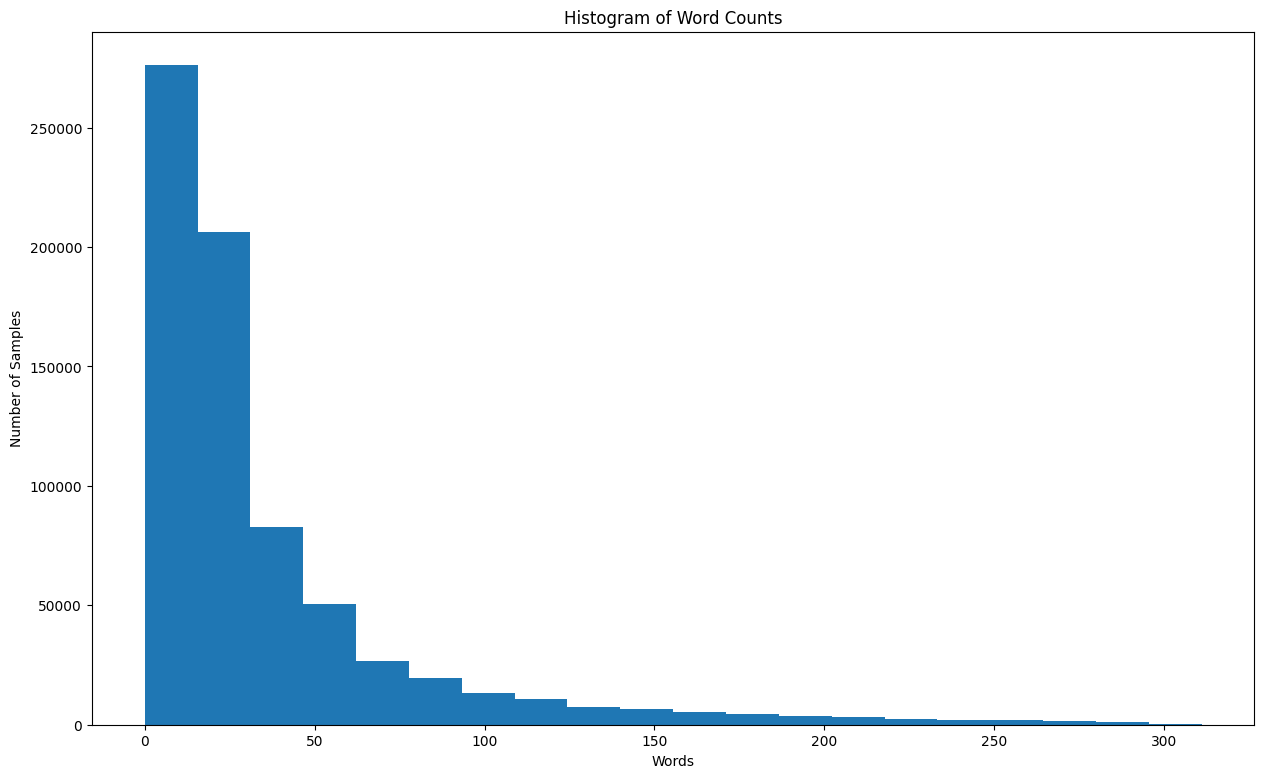

In [6]:
plt.figure(figsize=(15,9))
plt.hist(sequence_lens, bins=20,range = (0,311))
plt.xlabel("Words")
plt.ylabel("Number of Samples")
plt.title("Histogram of Word Counts");


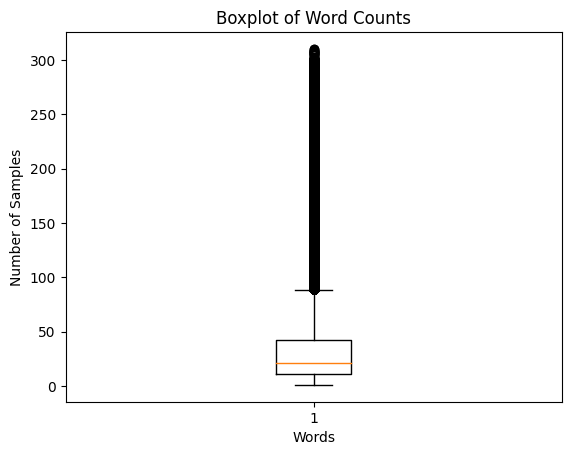

In [7]:
plt.boxplot(sequence_lens)
plt.xlabel("Words")
plt.ylabel("Number of Samples")
plt.title("Boxplot of Word Counts");

In [8]:
# Split the dataset into train and temp sets
temp_df, _ = train_test_split(df, test_size=0.5, stratify=df['Label'], random_state=42)

# Split the temp set into train and temp sets
train_df, temp2_df = train_test_split(temp_df, test_size=0.20, stratify=temp_df['Label'], random_state=42)

# Split the temp set into val train and test sets
val_df, test_df = train_test_split(temp2_df, test_size=0.5, stratify=temp2_df['Label'], random_state=42)

In [9]:
temp_df_counts = temp_df['Label'].value_counts().sort_index()
temp_df_counts

0    180797
1    182262
Name: Label, dtype: int64

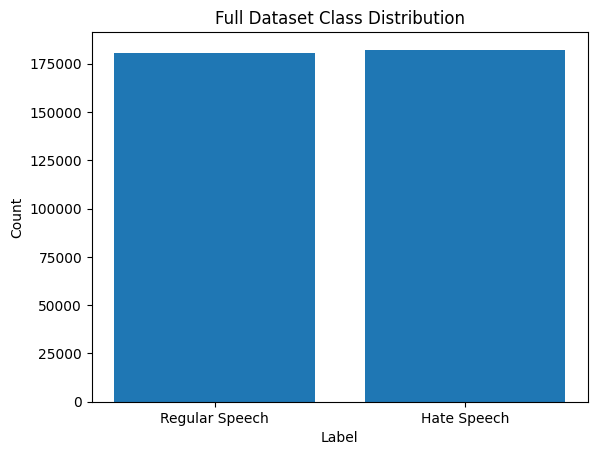

In [10]:
plt.bar(temp_df_counts.index, temp_df_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Full Dataset Class Distribution')
plt.xticks(temp_df_counts.index, ['Regular Speech', 'Hate Speech'])
plt.show()

In [11]:
train_distribution = train_df.Label.value_counts().sort_index()
train_distribution

0    144638
1    145809
Name: Label, dtype: int64

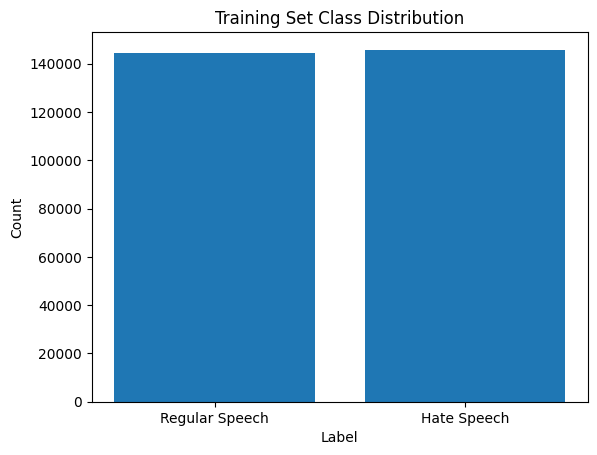

In [12]:
plt.bar(train_distribution.index, train_distribution.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Training Set Class Distribution')
plt.xticks(temp_df_counts.index, ['Regular Speech', 'Hate Speech'])
plt.show()

In [13]:
val_distribution = val_df.Label.value_counts().sort_index()
val_distribution

0    18079
1    18227
Name: Label, dtype: int64

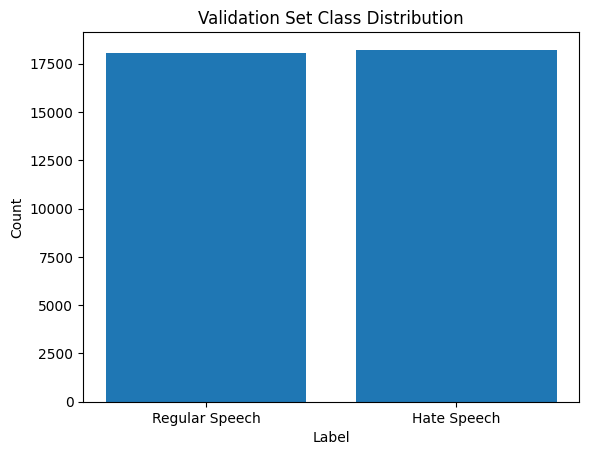

In [14]:
plt.bar(val_distribution.index, val_distribution.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Validation Set Class Distribution')
plt.xticks(val_distribution.index, ['Regular Speech', 'Hate Speech'])  # Replace with your class labels if needed
plt.show()

In [15]:
test_distribution = test_df.Label.value_counts().sort_index()
test_distribution

0    18080
1    18226
Name: Label, dtype: int64

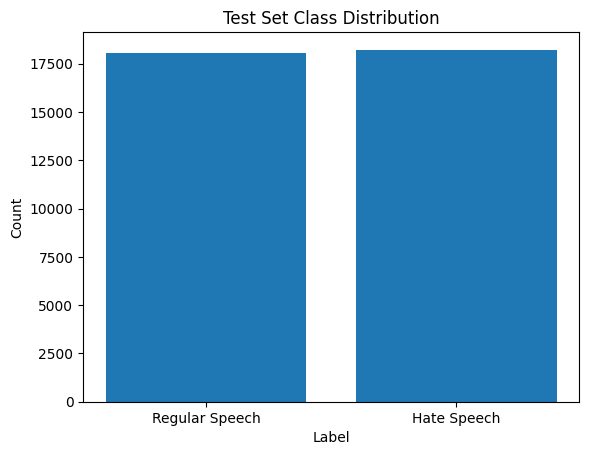

In [16]:
plt.bar(test_distribution.index, test_distribution.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Test Set Class Distribution')
plt.xticks(test_distribution.index, ['Regular Speech', 'Hate Speech'])
plt.show()

In [17]:
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")

def reshape_element(text, label):
    text = tf.reshape(text, shape=(1,))
    label = tf.reshape(label, shape=(1,))
    return text, label

nltk.download('stopwords',quiet=True)
STOPWORDS = stopwords.words("english")
batch_size = 128

In [18]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df['Content'].values, train_df['Label'].values)).map(reshape_element, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_df['Content'].values, val_df['Label'].values)).map(reshape_element, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((test_df['Content'].values, test_df['Label'].values)).map(reshape_element, num_parallel_calls=tf.data.AUTOTUNE)

# Unbatch the dataset to get variable-length tensors
train_ds = train_ds.unbatch()
val_ds = val_ds.unbatch()
test_ds = test_ds.unbatch()

# Create prefetch datasets with the desired element_spec
train_ds = train_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
text_only_train_ds =train_ds.map(lambda x, y: x)

In [20]:
max_length = 300
max_tokens = 50000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [21]:
# import pickle
# pickle.dump({'config': text_vectorization.get_config(),
#              'weights': text_vectorization.get_weights()}
#             , open("/content/drive/MyDrive/vectorizer.pkl", "wb"))

# print ("*"*10)
# Later you can unpickle and use
# `config` to create object and
# `weights` to load the trained weights.

# from_disk = pickle.load(open("tv_layer.pkl", "rb"))
# new_v = TextVectorization.from_config(from_disk['config'])
# # You have to call `adapt` with some dummy data (BUG in Keras)
# new_v.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
# new_v.set_weights(from_disk['weights'])

# # Lets see the Vector for word "this"
# print (new_v("this"))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         12800000  
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              123648    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                           

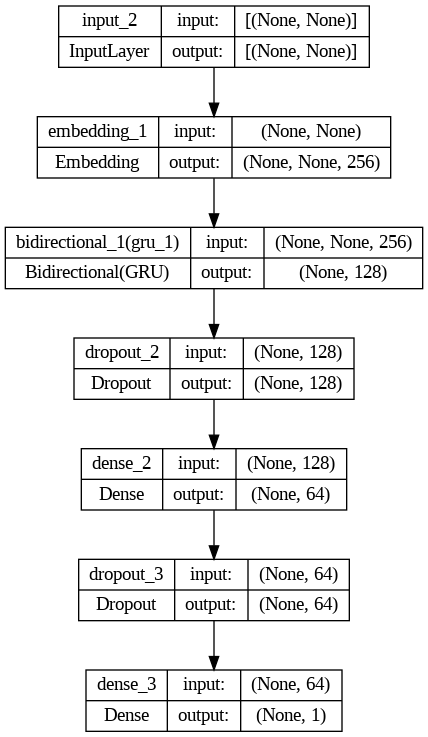

In [36]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens
                            ,output_dim=256
                            ,mask_zero=True)(inputs)
x = layers.Bidirectional(layers.GRU(64))(embedded)
x = layers.Dropout(0.5)(x)
x = layers.Dense(units=64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="BinaryCrossentropy",
              metrics=["accuracy"])
model.summary()


callbacks = [
    tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/GRU_50000_vocab.h5", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_accuracy', restore_best_weights=True)
]

# Plot model architecture
plot_model(model, show_shapes=True, show_layer_names=True)

In [37]:
history=model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, batch_size=128, callbacks=callbacks)

Epoch 1/10
2270/2270 [==============================] - 348s 150ms/step - loss: 0.4118 - accuracy: 0.8114 - val_loss: 0.3723 - val_accuracy: 0.8317
Epoch 2/10
2270/2270 [==============================] - 283s 125ms/step - loss: 0.3460 - accuracy: 0.8485 - val_loss: 0.3601 - val_accuracy: 0.8371
Epoch 3/10
2270/2270 [==============================] - 284s 125ms/step - loss: 0.3112 - accuracy: 0.8678 - val_loss: 0.3566 - val_accuracy: 0.8434
Epoch 4/10
2270/2270 [==============================] - 283s 125ms/step - loss: 0.2788 - accuracy: 0.8857 - val_loss: 0.3923 - val_accuracy: 0.8391
Epoch 5/10
2270/2270 [==============================] - 282s 124ms/step - loss: 0.2487 - accuracy: 0.9019 - val_loss: 0.4057 - val_accuracy: 0.8372


In [38]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_dict = history.history
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.412,0.811,0.372,0.832
1,0.346,0.848,0.360,0.837
2,0.311,0.868,0.357,0.843
3,0.279,0.886,0.392,0.839
4,0.249,0.902,0.406,0.837


<ipython-input-3-273406cf14be>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


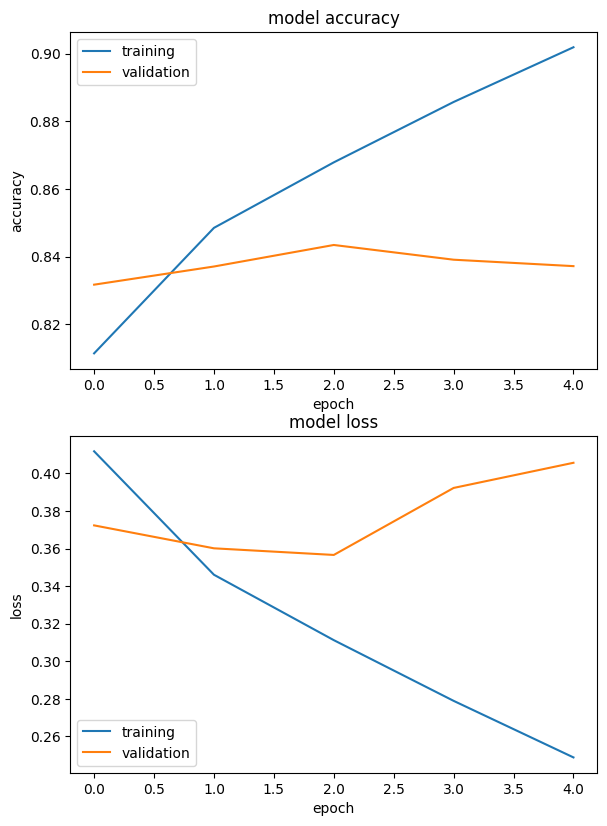

In [39]:
plt.subplots(figsize=(6,8))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [40]:
model = keras.models.load_model('/content/drive/MyDrive/GRU_50000_vocab.h5')

In [41]:
print(f"Training acc: {model.evaluate(int_train_ds)[1]:.3f}")

2270/2270 [==============================] - 56s 24ms/step - loss: 0.2692 - accuracy: 0.8883
Training acc: 0.888


In [42]:
print(f"Validation acc: {model.evaluate(int_val_ds)[1]:.3f}")

284/284 [==============================] - 6s 21ms/step - loss: 0.3566 - accuracy: 0.8434
Validation acc: 0.843


In [43]:
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

284/284 [==============================] - 7s 24ms/step - loss: 0.3542 - accuracy: 0.8442
Test acc: 0.844


In [44]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=-1)
predictions = model.predict(int_test_ds)
pred_classes = (predictions > 0.5).astype(int)

284/284 [==============================] - 9s 24ms/step


In [45]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.83      0.84     18080
           1       0.84      0.86      0.85     18226

    accuracy                           0.84     36306
   macro avg       0.84      0.84      0.84     36306
weighted avg       0.84      0.84      0.84     36306

Accuracy Score: 0.8442130777281992
Root Mean Square Error: 0.394698520736778


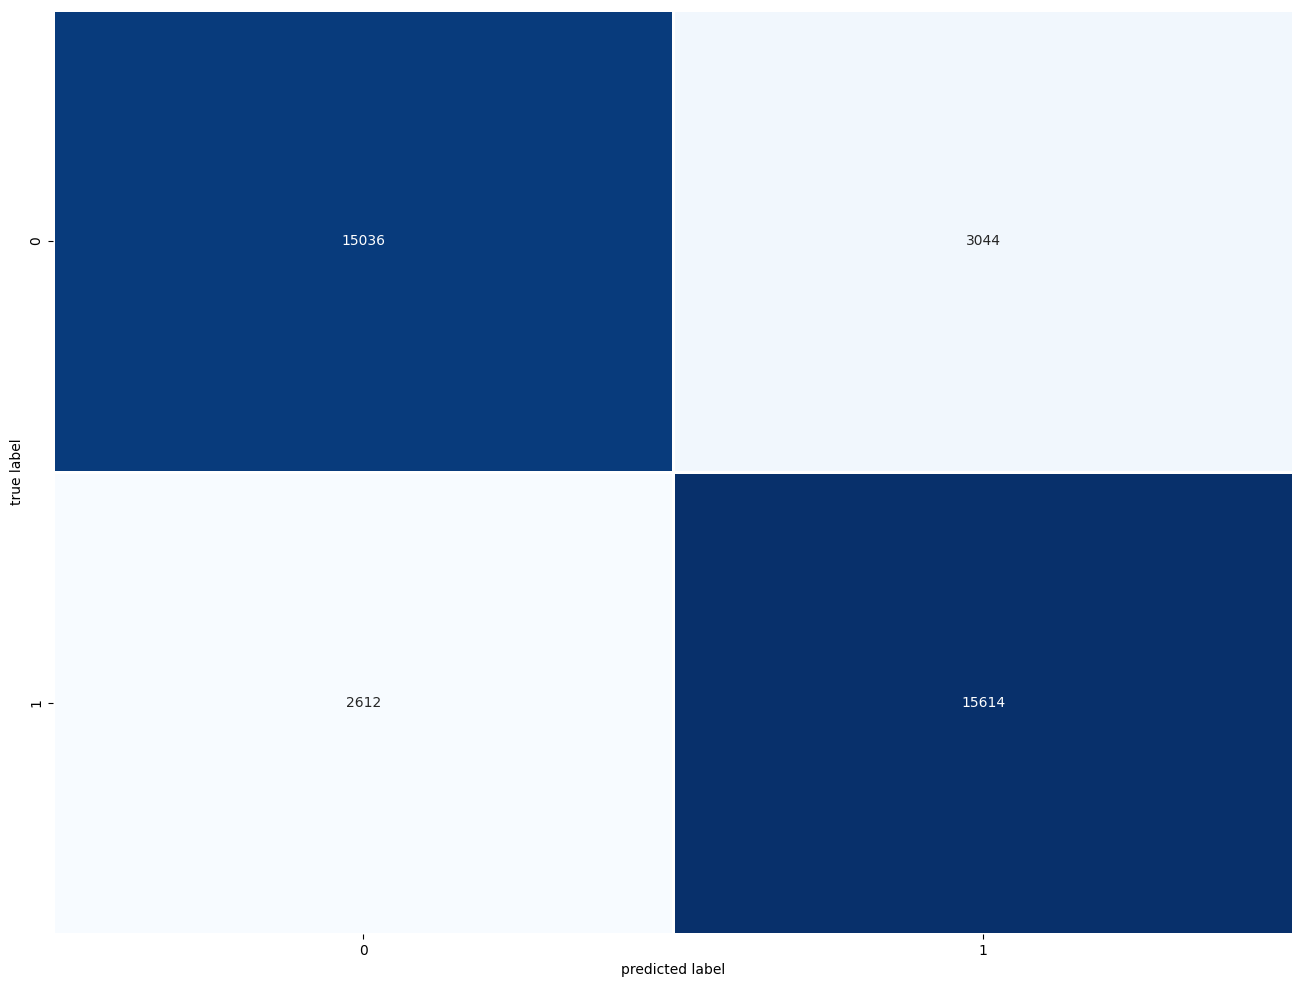

In [46]:
plot_confusion_matrix(y_test,pred_classes)

In [47]:
model.layers

In [48]:
embedding_layer = model.layers[1]
embedding_config = embedding_layer.get_config()
embedding_weights = embedding_layer.get_weights()

import json

# Save the configuration to a JSON file
with open('/content/drive/MyDrive/embedding_config.json', 'w') as json_file:
    json.dump(embedding_config, json_file)